In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
#!python '/content/drive/My Drive/DL Internship/3DCNN/3dcnn.py' --batch 32 --epoch 1 --videos '/content/drive/My Drive/DL Internship/Dataset(videos)/cropped videos' --nclass 5 --output '/content/drive/My Drive/DL Internship/3DCNN/result' --color True --skip False --depth 10

In [ ]:
import argparse
import os
import matplotlib
matplotlib.use('AGG')
import matplotlib.pyplot as plt
import numpy as np
from keras.datasets import cifar10
from keras.layers import (Activation, Conv3D, Dense, Dropout, Flatten, MaxPooling3D, BatchNormalization)
from keras.layers.advanced_activations import LeakyReLU
from keras.losses import categorical_crossentropy
from keras.models import Sequential
from keras.optimizers import Adam
from keras.utils import np_utils
from keras.utils.vis_utils import plot_model
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import numpy as np
import cv2
from easydict import EasyDict
%matplotlib inline

In [ ]:
class Videoto3D:

    def __init__(self, width, height, depth):
        self.width = width
        self.height = height
        self.depth = depth

    def video3d(self, filename, color=False, skip=True):
        print("test ",filename)
        cap = cv2.VideoCapture(filename)
        nframe = cap.get(cv2.CAP_PROP_FRAME_COUNT)
        if skip:
            frames = [x * nframe / self.depth for x in range(self.depth)]
        else:
            frames = [x for x in range(self.depth)]
        framearray = []

        for i in range(self.depth):
            cap.set(cv2.CAP_PROP_POS_FRAMES, frames[i])
            ret, frame = cap.read()
            frame = cv2.resize(frame, (self.height, self.width))
            if color:
                framearray.append(frame)
            else:
                framearray.append(cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY))

        cap.release()
        return np.array(framearray)

    def get_UCF_classname(self, filename):
        return filename[filename.find('_') + 1:filename.find('_', 2)]

In [ ]:
def save_history(history, result_dir):
    loss = history.history['loss']
    acc = history.history['accuracy']
    val_loss = history.history['val_loss']
    val_acc = history.history['val_accuracy']
    nb_epoch = len(acc)

    with open(os.path.join(result_dir, '3DCNNresult.txt'), 'w') as fp:
        fp.write('epoch\tloss\tacc\tval_loss\tval_acc\n')
        for i in range(nb_epoch):
            fp.write('{}\t{}\t{}\t{}\t{}\n'.format(
                i, loss[i], acc[i], val_loss[i], val_acc[i]))

In [ ]:
def loaddata(video_dir, vid3d, nclass, result_dir, color=False, skip=True):
    folders = os.listdir(video_dir)
    X = []
    labels = []
    labellist = []

    for folder in folders:
      files = os.listdir(video_dir+"/"+folder)
      pbar = tqdm(total=len(files))
      for filename in files:
          pbar.update(1)
          if filename == '.DS_Store':
              continue
          name = os.path.join(video_dir+"/"+folder, filename)
          # label = vid3d.get_UCF_classname(folder)
          label = folder
          if label not in labellist:
              if len(labellist) >= nclass:
                  continue
              labellist.append(label)
          labels.append(label)
          X.append(vid3d.video3d(name, color=color, skip=skip))

      pbar.close()
    with open(os.path.join(result_dir, 'classes.txt'), 'w') as fp:
        for i in range(len(labellist)):
            fp.write('{}\n'.format(labellist[i]))

    for num, label in enumerate(labellist):
        for i in range(len(labels)):
            if label == labels[i]:
                labels[i] = num
    if color:
        return np.array(X).transpose((0, 2, 3, 4, 1)), labels
    else:
        return np.array(X).transpose((0, 2, 3, 1)), labels

In [ ]:
args = EasyDict({
    "batch": 32,
    "epoch": 10,
    "videos":'/content/drive/My Drive/videos',
    "nclass":23,
    "color":True,
    "skip":False,
    "depth":12,
    "output": '/content/drive/My Drive/FinalResult3DCNN/Output'
})

In [ ]:
img_rows, img_cols, frames = 32, 32, args.depth
channel = 3 if args.color else 1
fname_npz = args.output+'/dataset_{}_{}_{}.npz'.format(
    args.nclass, args.depth, args.skip)


vid3d = Videoto3D(img_rows, img_cols, frames)
nb_classes = args.nclass
if os.path.exists(fname_npz):
    loadeddata = np.load(fname_npz)
    X, Y = loadeddata["X"], loadeddata["Y"]
else:
    x, y = loaddata(args.videos, vid3d, args.nclass,
                    args.output, args.color, args.skip)
    X = x.reshape((x.shape[0], img_rows, img_cols, frames, channel))
    Y = np_utils.to_categorical(y, nb_classes)

    X = X.astype('float32')
    np.savez(fname_npz, X=X, Y=Y)
    print('Saved dataset to dataset.npz.')
print('X_shape:{}\nY_shape:{}'.format(X.shape, Y.shape))

X_shape:(11758, 32, 32, 12, 3)
Y_shape:(11758, 23)


# New Section

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_7 (Conv3D)            (None, 32, 32, 12, 32)    800       
_________________________________________________________________
activation_7 (Activation)    (None, 32, 32, 12, 32)    0         
_________________________________________________________________
conv3d_8 (Conv3D)            (None, 32, 32, 12, 32)    8224      
_________________________________________________________________
activation_8 (Activation)    (None, 32, 32, 12, 32)    0         
_________________________________________________________________
max_pooling3d_4 (MaxPooling3 (None, 16, 16, 6, 32)     0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 16, 16, 6, 32)     0         
_________________________________________________________________
conv3d_9 (Conv3D)            (None, 16, 16, 6, 64)    

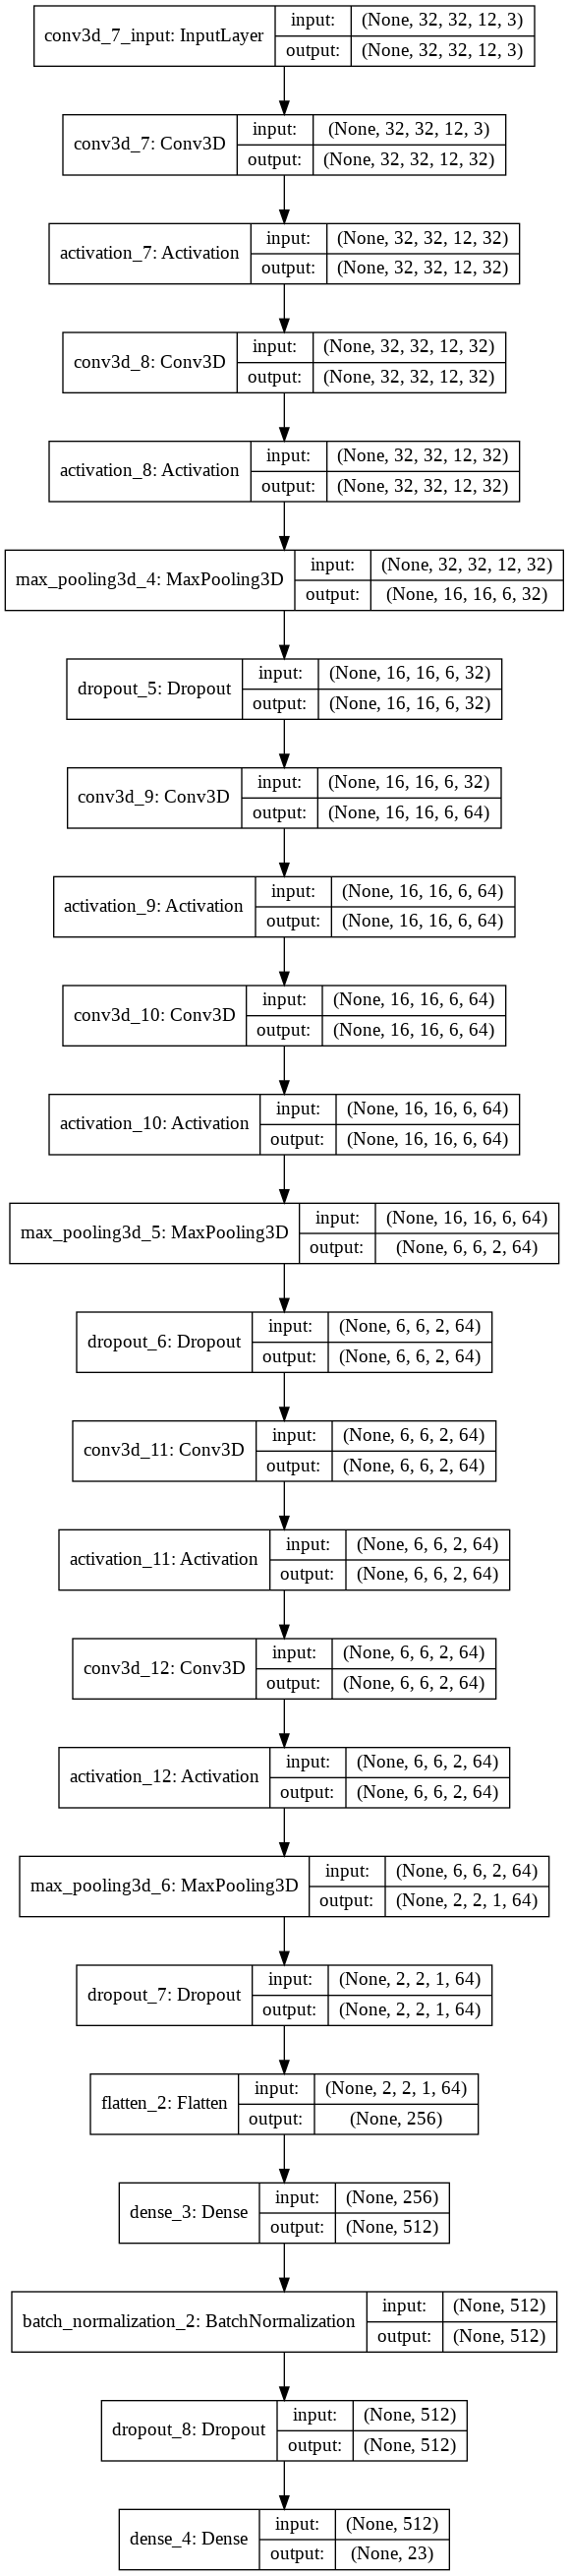

In [ ]:
# Define model
model = Sequential()
model.add(Conv3D(32, kernel_size=(2, 2, 2), input_shape=(X.shape[1:]), padding="same"))
model.add(Activation('relu'))
model.add(Conv3D(32, padding="same", kernel_size=(2, 2, 2)))
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2), padding="same"))
model.add(Dropout(0.05))

model.add(Conv3D(64, padding="same", kernel_size=(2, 2, 2)))
model.add(Activation('relu'))
model.add(Conv3D(64, padding="same", kernel_size=(2, 2, 2)))
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(3, 3, 3), padding="same"))
model.add(Dropout(0.05))

model.add(Conv3D(64, padding="same", kernel_size=(3, 3, 3)))
model.add(Activation('relu'))
model.add(Conv3D(64, padding="same", kernel_size=(3, 3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(3, 3, 3), padding="same"))
model.add(Dropout(0.05))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.05))
model.add(Dense(nb_classes, activation='softmax'))

model.compile(loss=categorical_crossentropy,
              optimizer=Adam(), metrics=['accuracy'])
model.summary()
plot_model(model, show_shapes=True,
            to_file=os.path.join(args.output, '3DCNNmodel.png'))

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split( X, Y, test_size=0.2, random_state=43)

history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), batch_size=args.batch,
                    epochs=args.epoch, verbose=1, shuffle=True)

Train on 9406 samples, validate on 2352 samples
Epoch 1/10
9406/9406 [==============================] - 928s 99ms/step - loss: 2.6910 - accuracy: 0.1727 - val_loss: 3.3681 - val_accuracy: 0.1769
Epoch 2/10
9406/9406 [==============================] - 926s 98ms/step - loss: 2.1958 - accuracy: 0.2781 - val_loss: 2.7527 - val_accuracy: 0.2228
Epoch 3/10
9406/9406 [==============================] - 922s 98ms/step - loss: 1.1001 - accuracy: 0.6500 - val_loss: 0.8677 - val_accuracy: 0.7832
Epoch 4/10
9406/9406 [==============================] - 923s 98ms/step - loss: 0.6001 - accuracy: 0.8127 - val_loss: 0.2933 - val_accuracy: 0.9201
Epoch 5/10
9406/9406 [==============================] - 922s 98ms/step - loss: 0.2678 - accuracy: 0.9171 - val_loss: 0.2390 - val_accuracy: 0.9260
Epoch 6/10
9406/9406 [==============================] - 923s 98ms/step - loss: 0.1888 - accuracy: 0.9414 - val_loss: 0.2252 - val_accuracy: 0.9311
Epoch 7/10
9406/9406 [==============================] - 926s 98ms/step

In [ ]:
model.evaluate(X_test, Y_test, verbose=0)

[0.24094173435096433, 0.9392006993293762]

In [ ]:
model_json = model.to_json()
if not os.path.isdir(args.output):
    os.makedirs(args.output)
with open(os.path.join(args.output, '3DCNNmodel.json'), 'w') as json_file:
    json_file.write(model_json)
model.save_weights(os.path.join(args.output, '3DCNNmodel.hd5'))
loss, acc = model.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', acc)

Test loss: 0.24094173435096433
Test accuracy: 0.9392006993293762


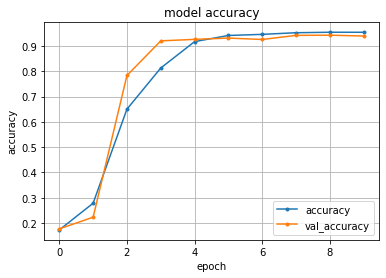

In [ ]:
save_history(history, args.output)
plt.plot(history.history['accuracy'], marker='.')
plt.plot(history.history['val_accuracy'], marker='.')
plt.title('model accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.grid()
plt.legend(['accuracy', 'val_accuracy'], loc='lower right')
plt.savefig(os.path.join(args.output, 'model_accuracy.png'))
plt.show()

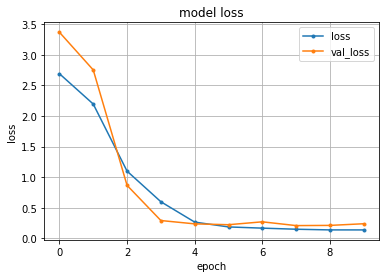

In [ ]:
plt.plot(history.history['loss'], marker='.')
plt.plot(history.history['val_loss'], marker='.')
plt.title('model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid()
plt.legend(['loss', 'val_loss'], loc='upper right')
plt.savefig(os.path.join(args.output, 'model_loss.png'))
plt.show()

In [ ]:
# Prepare data for prediction
img_rows, img_cols, frames = 32, 32, args.depth
channel = 3 if args.color else 1
vid3d = Videoto3D(img_rows, img_cols, frames)
test_data = vid3d.video3d('/content/drive/My Drive/videos/Abuse/Abuse001_x264_10.mp4', color=args.color, skip=args.skip)
t = np.expand_dims(test_data, axis=0)
print(t.shape)
td = np.array(t).transpose((0, 2, 3, 1, 4))
print(td.shape)
ls = [test_data]

test  /content/drive/My Drive/videos/Abuse/Abuse001_x264_10.mp4
(1, 12, 32, 32, 3)
(1, 32, 32, 12, 3)


In [ ]:
from keras.models import load_model
from keras.models import model_from_json
import json
with open(os.path.join(args.output, '3DCNNmodel.json'),'r') as f:
    print(type(f))
    for i in f:
      print(type(i))
      model_json = i
      break

model = model_from_json(model_json)
model.load_weights(os.path.join(args.output, '3DCNNmodel.hd5'))

<class '_io.TextIOWrapper'>
<class 'str'>


In [ ]:
# Predict.
predictions = model.predict(td)
print(predictions)

[[2.3253977e-08 4.7297299e-10 6.1899490e-09 3.0252927e-08 1.5700483e-09
  3.6926519e-08 5.6706906e-09 6.1789200e-09 2.1930149e-10 1.1186893e-08
  9.9996960e-01 9.2223109e-09 1.5374919e-05 1.3147378e-07 1.0771311e-07
  2.8417921e-09 1.7822259e-07 2.3507409e-06 1.1430812e-09 1.0272130e-05
  3.3198670e-11 1.8029274e-06 2.0723847e-09]]


In [ ]:
# Process predicted result
class_names = ['digging',
'openclosetrunk',
'running',
'carrying',
'clapping',
'jogging',
'boxing',
'walking',
'waving',
'throwing',
'Abuse',
'Arrest',
'Arson',
'Assault',
'Fighting',
'Explosion',
'Shooting',
'Shoplifting',
'Vandalism',
'Burglary',
'Robbery',
'RoadAccidents',
'Stealing']
class_names[np.argmax(predictions)]

'Abuse'